In [1]:
!pip install transformers accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-2ofp_2zx
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-2ofp_2zx
  Resolved https://github.com/huggingface/diffusers to commit 07860f991639f35f4b5a152676bd4d590c3e589e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


# Load MNIST

In [2]:
from datasets import load_dataset, Dataset, DatasetDict

ds = load_dataset("zalando-datasets/fashion_mnist")

In [3]:
for f in ds.keys():
    print(f)

train
test


In [4]:
ds["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [5]:
d=ds["train"][0]
d["image"], d["image"].size

(<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>, (28, 28))

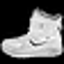

In [6]:
d["image"].resize((64,64))

# Load DCAE

In [7]:
import torch
from diffusers import AutoencoderDC

model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

# PIL to latent

In [8]:
import torchvision.transforms as T

def encode_pil(image, ae):
    # FASHION MNIST inputs are grayscale/BW
    image = image.convert('RGB')
    transform = T.Compose([
        T.Resize(64, antialias=True),
        T.CenterCrop(64),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        lambda x: x.to(dtype=torch.bfloat16)
    ])

    image_tensor = transform(image)[None].to(device)

    with torch.no_grad():
        latent = ae.encode(image_tensor)
    return latent.latent

latent = encode_pil(d["image"], dcae)
latent.shape

torch.Size([1, 32, 2, 2])

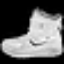

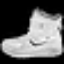

In [9]:
img = ds["train"][0]["image"]
display(img)
img = T.Resize(64, antialias=True)(img)
display(img)
img = T.CenterCrop(64)(img)
display(img)



(28, 28) torch.Size([1, 32, 2, 2])


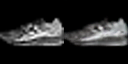

(28, 28) torch.Size([1, 32, 2, 2])


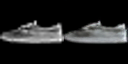

(28, 28) torch.Size([1, 32, 2, 2])


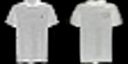

(28, 28) torch.Size([1, 32, 2, 2])


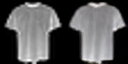

(28, 28) torch.Size([1, 32, 2, 2])


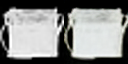

(28, 28) torch.Size([1, 32, 2, 2])


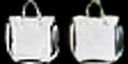

(28, 28) torch.Size([1, 32, 2, 2])


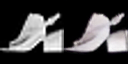

(28, 28) torch.Size([1, 32, 2, 2])


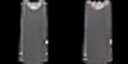

(28, 28) torch.Size([1, 32, 2, 2])


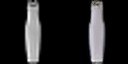

(28, 28) torch.Size([1, 32, 2, 2])


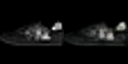

(28, 28) torch.Size([1, 32, 2, 2])


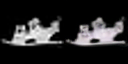

(28, 28) torch.Size([1, 32, 2, 2])


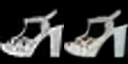

(28, 28) torch.Size([1, 32, 2, 2])


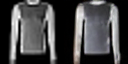

(28, 28) torch.Size([1, 32, 2, 2])


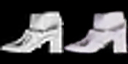

(28, 28) torch.Size([1, 32, 2, 2])


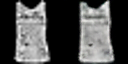

(28, 28) torch.Size([1, 32, 2, 2])


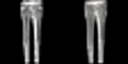

(28, 28) torch.Size([1, 32, 2, 2])


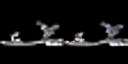

(28, 28) torch.Size([1, 32, 2, 2])


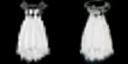

(28, 28) torch.Size([1, 32, 2, 2])


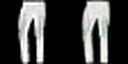

(28, 28) torch.Size([1, 32, 2, 2])


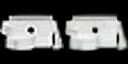

In [11]:
from utils import make_grid, latent_to_PIL

# test a few dataset items
for d in ds["train"].shuffle().select(range(20)):
    img = d["image"]
    latent = encode_pil(img, dcae)
    print(img.size, latent.shape)
    display(make_grid([
        img.resize((64,64)),
        latent_to_PIL(latent, dcae),
    ], 1, 2))


# Test batch processing

In [12]:
def batch_PIL_to_latent(images, ae):
    transform = T.Compose([
        T.Resize(64, antialias=True),
        T.CenterCrop(64),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        lambda x: x.to(dtype=torch.bfloat16)
    ])
    
    images_tensors = torch.cat([transform(image.convert("RGB"))[None] for image in images])
    
    with torch.no_grad():
        latents = ae.encode(images_tensors.to(ae.device)).latent
    return latents


In [13]:
from torch.utils.data import DataLoader

def my_collate(batch):
    labels = [item["label"] for item in batch]
    images = [item["image"] for item in batch]
    return [labels, images]
    
dataloader = DataLoader(ds["train"], batch_size=2, collate_fn=my_collate)
labels, images = next(iter(dataloader))
latents = batch_PIL_to_latent(images, dcae)
len(labels), len(images), latents.shape

(2, 2, torch.Size([2, 32, 2, 2]))

# Process dataset and upload

In [14]:
from tqdm import tqdm

dataset_latents = {}
splits = ds.keys()
bs = 64

for split in splits:
    print(split)
    dataset_latents[split]=[]
    dataloader = DataLoader(ds[split], batch_size=bs, collate_fn=my_collate)
    
    for labels, images in tqdm(dataloader):        
        latents = batch_PIL_to_latent(images, dcae).float().cpu()
        for i in range(latents.size(0)):
            dataset_latents[split].append({
                "label": labels[i],
                "latent": latents[i].unsqueeze(0).numpy()
            })

train


100%|██████████| 938/938 [00:30<00:00, 30.99it/s]


test


100%|██████████| 157/157 [00:05<00:00, 31.07it/s]


In [15]:
dataset = DatasetDict({split: Dataset.from_list(dataset_latents[split]) for split in dataset_latents.keys()})
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'latent'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['label', 'latent'],
        num_rows: 10000
    })
})

9


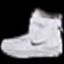

In [16]:
d=dataset["train"][0]
print(d["label"])
latent_to_PIL(torch.Tensor(d["latent"]).to(torch.bfloat16).to(device), dcae)

In [18]:
from local_secrets import hf_token, wandb_key
from huggingface_hub import login

login(token=hf_token)

In [19]:
dataset.push_to_hub("g-ronimo/FMNIST-latents-64_dc-ae-f32c32-sana-1.0", private=False, commit_message=model)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/60 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/g-ronimo/FMNIST-latents-64_dc-ae-f32c32-sana-1.0/commit/003b8f63876a467e45e05e8b5f08bf7b7f0abb56', commit_message='Efficient-Large-Model/Sana_600M_1024px_diffusers', commit_description='', oid='003b8f63876a467e45e05e8b5f08bf7b7f0abb56', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/g-ronimo/FMNIST-latents-64_dc-ae-f32c32-sana-1.0', endpoint='https://huggingface.co', repo_type='dataset', repo_id='g-ronimo/FMNIST-latents-64_dc-ae-f32c32-sana-1.0'), pr_revision=None, pr_num=None)